# Exploring QVEC

I want to spend some time now looking closer at QVEC's output, namely the correlations and the alignment matrix. The second main point of the original paper is that the alignments allow you to interpret individual dimensions of embeddings.

In [163]:
%matplotlib inline
import os
import csv
from itertools import product
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

data_path = '../../data'
tmp_path = '../../tmp'

### Linguistic features

In [2]:
feature_path = os.path.join(data_path, 'evaluation/semcor/tsvetkov_semcor.csv')
subset = pd.read_csv(feature_path, index_col=0)
subset.columns = [c.replace('semcor.', '') for c in subset.columns]
subset.set_index('words', inplace=True)
subset = subset.T

### Learnt embeddings

In [3]:
size = 300
fname = 'embeddings/glove.6B.{}d.txt'.format(size)
embedding_path = os.path.join(data_path, fname)
embeddings = pd.read_csv(embedding_path, sep=' ', header=None, index_col=0, quoting=csv.QUOTE_NONE).T

### QVEC model

In [4]:
def qvec(features, embeddings):
    """
    Returns correlations between columns of `features` and `embeddings`.
    
    The aligned feature is the one with the highest correlation.
    The qvec score is the sum of correlations of aligned features.
    """
    common_words = embeddings.columns.intersection(features.columns)
    S = features[common_words]
    X = embeddings[common_words]
    correlations = pd.DataFrame({i:X.corrwith(S.iloc[i], axis=1) for i in range(len(S))})
    correlations.columns = S.index
    return correlations

In [5]:
correlations = qvec(subset, embeddings)
V = len(embeddings.columns.intersection(subset.columns))

In [6]:
correlations.head()

,noun.Tops,noun.act,noun.animal,noun.artifact,noun.attribute,noun.body,noun.cognition,noun.communication,noun.event,noun.feeling,...,verb.consumption,verb.contact,verb.creation,verb.emotion,verb.motion,verb.perception,verb.possession,verb.social,verb.stative,verb.weather
1,-0.025195,0.103305,0.022804,0.019960,-0.005073,-0.063040,0.001746,-0.044627,0.060426,-0.000629,...,-0.000923,0.032615,-0.059228,0.002191,0.043395,0.016654,-0.000253,0.015861,-0.058195,0.027505
2,0.025052,0.003521,0.071996,0.033976,0.046986,0.000275,-0.025890,-0.093323,0.013002,-0.026363,...,0.041451,0.004752,0.008058,-0.024316,-0.043428,0.021968,-0.003188,0.024070,0.064498,-0.034473
3,0.000335,0.132868,-0.020388,-0.043322,0.026484,-0.031252,0.051305,0.025105,0.069223,0.112211,...,-0.009357,-0.078781,-0.096304,-0.000102,-0.010545,-0.015110,-0.082116,-0.047947,-0.098220,0.008797
4,0.003880,0.020326,0.023546,-0.164084,-0.013492,-0.079157,0.008527,0.045884,-0.002118,-0.003778,...,0.031046,-0.015342,-0.029799,0.009851,0.045801,-0.023565,0.036102,0.003050,0.059049,-0.009769
5,0.011347,0.032593,0.008034,-0.031921,-0.015440,0.030811,0.026431,-0.020380,-0.054214,0.032733,...,-0.006414,-0.024326,-0.012067,0.045959,-0.026189,-0.051913,0.013840,-0.012455,0.000732,-0.006095


## Exploration

#### What dimensions and features are aligned?

The dataframe below is as follows: index is the dimension of the learnt embedding, 'feature' is the name of the linguistic feature aligned with that dimension, and 'max_corr' is the correlation between the dimension and feature. The sum of the 'max_corr' column is the qvec score.

39 dimensions pick out 'noun.person', 37 'noun.artifact', 19 'noun.body', 15 'verb.change'.

In [171]:
alignments = pd.DataFrame(correlations.idxmax(axis=1))
alignments.columns = ['feature']
alignments['max_corr'] = correlations.max(axis=1)
alignments.sort_values(by='max_corr', ascending=False).head(10)

,feature,max_corr
122,noun.person,0.318956
255,noun.person,0.288418
91,noun.artifact,0.268320
54,noun.person,0.254084
245,noun.person,0.224563
300,noun.person,0.215958
151,noun.group,0.207835
235,noun.artifact,0.204042
187,noun.artifact,0.200060
182,noun.person,0.197632


#### What is QVEC doing?

QVEC is looking at 41 correlation coefficients (or as many linguistic features as there are) and finding the maximum. Here, I show the relevant scatterplot for the highest correlation.

A consistent observation is that the distribution of the linguistic features are strongly peaked at 0. That is, almost all words have 0 for for most features. Sometimes, there is some mass at 1. This suggests to me that the linguistic features being used are not appropriate.

In [89]:
common_words = embeddings.columns.intersection(subset.columns)
S = subset[common_words]
X = embeddings[common_words]
def plot(i, j, X=X, S=S):
    """Plot ith dimension of embeddings against feature j."""
    x = X.loc[i]
    s = S.loc[j]
    sns.jointplot(x, s);

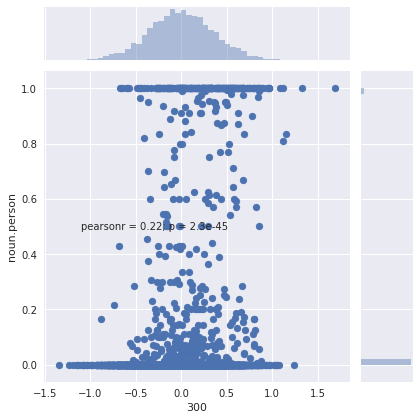

In [90]:
plot(300,'noun.person')

#### What do the learnt embeddings looks like?

**In sum: each dimension looks pretty normal, but the formal tests I'm using suggest otherwise. Most are centered at 0 with std around 0.4.**

From the marginal distribution plots above, it looks like each dimension is normally distributed. I don't know if that's purposively done during training or if it just turns out that way.

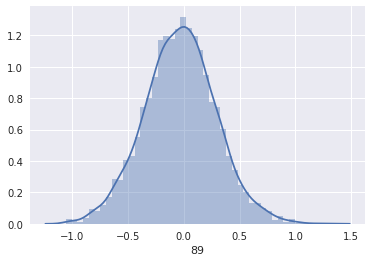

In [10]:
sns.distplot(X.loc[89]);

#### Graphical test of normality

I'm plotting a QQ plot and a probability plot side by side.

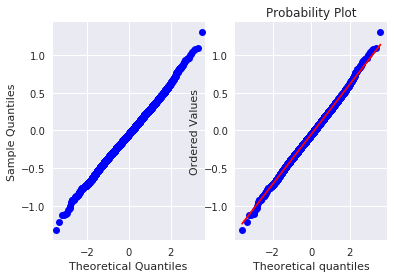

In [11]:
fig, axs = plt.subplots(1,2)
vector = X.loc[1]
sm.qqplot(vector, ax=axs[0]);
stats.probplot(vector, plot=axs[1]);

#### KS test

The preliminary results suggest that some dimensions are not normally distributed.

The KS test is clear, but I have some uncertainty about how to use it in scipy. In particular, do I give it the std or var of the distribution being tested? 

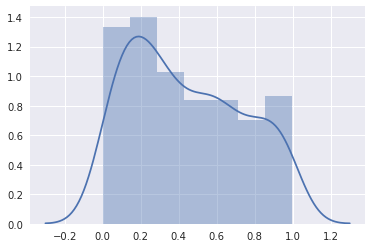

In [12]:
def do_kstest(i):
    vector = X.loc[i]
    ybar = vector.mean()
    s = vector.std()
    result = stats.kstest(vector, cdf='norm', args=(ybar, s))
    return result.pvalue

p_values = [do_kstest(i) for i in X.index]
sns.distplot(p_values);

#### Shapiro-Wilk test

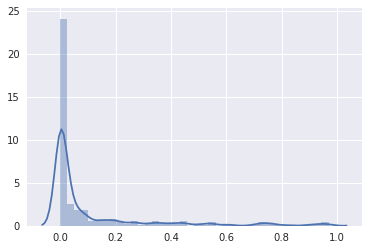

In [13]:
def do_shapirotest(i):
    vector = X.loc[i]
    result = stats.shapiro(vector)
    return result[1]

p_values = [do_shapirotest(i) for i in X.index]
sns.distplot(p_values);

#### Lilliefors test

In [14]:
def do_lillieforstest(i):
    vector = X.loc[i]
    result = sm.stats.lilliefors(vector)
    return result[1]

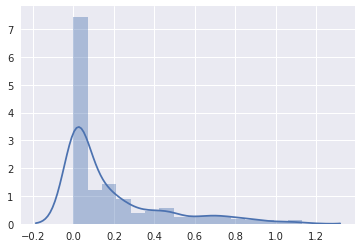

In [15]:
p_values = [do_lillieforstest(i) for i in X.index]
sns.distplot(p_values);

#### Location & spread of each dimension

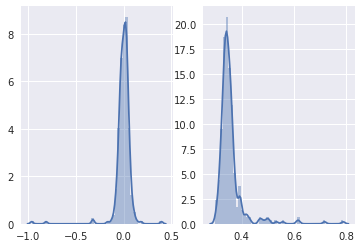

In [16]:
fig, axs = plt.subplots(1,2)
sns.distplot(X.mean(axis=1), ax=axs[0]);
sns.distplot(X.std(axis=1), ax=axs[1]);

#### What does each learnt embedding look like?

**In sum: Centered at 0 with std 0.4, but less clearly normal.**

How to answer this effectively?

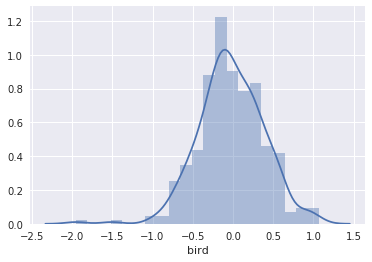

In [17]:
sns.distplot(X['bird']);

#### Location & spread of each word embedding

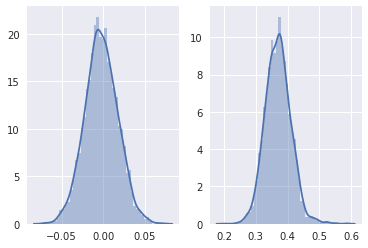

In [18]:
fig, axs = plt.subplots(1,2)
sns.distplot(X.mean(), ax=axs[0]);
sns.distplot(X.std(), ax=axs[1]);

#### What do the features look like?

**The features are strongly bimodal.** The usual summary statistics of mean, median and std are not appropriate for bimodal distributions.

If you were to randomly select a word, on average its feature representation would have 1.3% for an animal noun.

In [19]:
S.mean(axis=1).sort_values(ascending=False).head()

noun.artifact         0.100604
noun.person           0.081092
noun.act              0.066654
noun.communication    0.060680
verb.communication    0.050085
dtype: float64

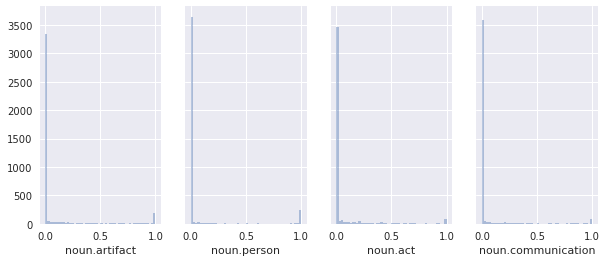

In [20]:
fig, axs = plt.subplots(ncols=4, figsize=(10, 4), sharey=True)
sns.distplot(S.loc['noun.artifact'], ax=axs[0], kde=False);
sns.distplot(S.loc['noun.person'], ax=axs[1], kde=False);
sns.distplot(S.loc['noun.act'], ax=axs[2], kde=False);
sns.distplot(S.loc['noun.communication'], ax=axs[3], kde=False);

#### What proportion of words in the vocab have a non-zero value for each feature?

On average across all 41 features, 6% of words have a nonzero entry for features. The highest proportion is 21%.

In [21]:
proportions = S.astype(bool).sum(axis=1) / len(S.columns)
print(proportions.sort_values(ascending=False).head())
proportions.describe()

noun.artifact         0.210702
noun.act              0.181796
noun.communication    0.151935
noun.person           0.135929
verb.communication    0.116579
dtype: float64


count    41.000000
mean      0.060783
std       0.048772
min       0.002628
25%       0.024606
50%       0.043717
75%       0.091495
max       0.210702
dtype: float64

#### How can I actually measure an association between linguistic features and learnt dimensions?

Knowing that the dimensions of the learnt embeddings are normally distributed and that the features are strongly bimodal, what is the best way to measure their correlation? It's clear that Pearson's $r$ and Spearman's $\rho$ are not appropriate because of the high number of ties.

I see two broad approaches:

- Remove all 0's and use Pearson's or Spearman's.
- Treat the feature as binary and compare means.

**In sum: Neither is very insightful. I need to use different (less sparse) features.**

#### Remove 0's

**In sum: Removing 0's seems to help, but is not principled. It picks out one extremely rare feature. The fact that removing 0's helps tells me the presence of such rare features is a problem.**

I changed the 0's to missing values and then use the usual QVEC code from above. I checked the source of `corrwith` and it looks like it ignores missing values, which is what I want.

The wierd thing is that one feature 'noun.motive' is the most highly correlated feature for 66 of the 300 dimensions. Most of the most highly correlated features are 'noun.motive'. Previously, it didn't appear at all. There are only 11 nonzero entries for it.

In [28]:
S_no_zeroes = S[(S != 0)]
S_no_zeroes.head()

words,in,a,be,have,will,one,two,more,first,up,...,epiphysis,alveolus,antiserum,quirt,polyphosphate,catkin,illumine,thyroglobulin,pushup,compulsivity
noun.Tops,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
noun.act,0.181818,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.322581,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
noun.animal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
noun.artifact,0.090909,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
noun.attribute,0.090909,NaN,NaN,NaN,0.111111,NaN,NaN,NaN,0.032258,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


In [33]:
tmp = qvec(S_no_zeroes, embeddings)
tmp.head()

,noun.Tops,noun.act,noun.animal,noun.artifact,noun.attribute,noun.body,noun.cognition,noun.communication,noun.event,noun.feeling,...,verb.consumption,verb.contact,verb.creation,verb.emotion,verb.motion,verb.perception,verb.possession,verb.social,verb.stative,verb.weather
1,-0.229182,0.111077,0.007209,0.037589,-0.083839,-0.227386,0.002934,-0.045626,-0.019186,-0.062111,...,0.073027,0.085515,-0.244246,-0.067874,0.068440,0.070704,-0.100652,0.013106,-0.167430,0.256932
2,0.202263,-0.008259,0.200702,-0.000356,0.113172,-0.024689,-0.072588,-0.178311,-0.051213,-0.149925,...,0.100824,-0.074187,-0.067437,-0.190583,-0.162674,0.028970,-0.054395,0.000717,0.154650,-0.111338
3,0.014284,0.214625,-0.075941,-0.117910,-0.020473,0.002985,0.049466,0.009423,0.171650,0.440297,...,0.087655,-0.040716,-0.241742,0.112286,0.066815,0.146187,-0.137460,-0.026873,-0.175116,0.181890
4,0.155118,0.049381,0.292984,-0.116676,0.000463,0.044785,0.116891,0.058691,0.084327,-0.093920,...,0.109172,0.019141,-0.081494,0.030214,0.161246,-0.153968,0.116954,-0.026835,0.241725,0.038425
5,-0.008214,0.055944,-0.049097,-0.014899,-0.069239,0.001092,-0.028705,-0.007390,-0.094735,0.062622,...,0.040004,-0.034280,-0.047176,0.085783,-0.065920,-0.261270,0.037078,-0.065048,-0.029855,0.198482


In [68]:
alignments = pd.DataFrame(tmp.idxmax(axis=1))
alignments.columns = ['feature']
alignments['max_corr'] = tmp.max(axis=1)
alignments.sort_values(by='max_corr', ascending=False).head()

,feature,max_corr
160,noun.motive,0.865133
164,noun.motive,0.727977
213,noun.motive,0.705146
200,noun.motive,0.678975
218,noun.motive,0.676393


The following dimensions and features were aligned previously:
- 122   noun.person
- 255	noun.person
- 91	noun.artifact
- 54	noun.person
- 245	noun.person

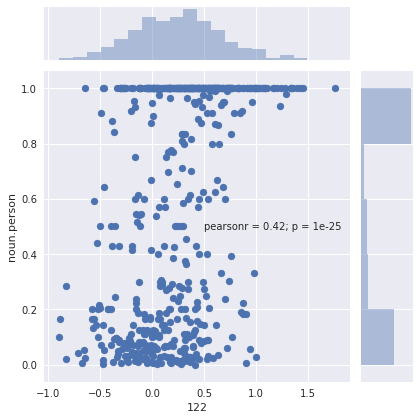

In [91]:
plot(122, 'noun.person', S=S_no_zeroes);

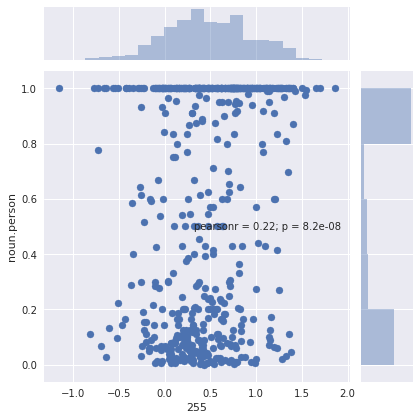

In [81]:
plot(255, 'noun.person', S=S_no_zeroes);

#### Treat linguistic features as binary

**In sum: I binarize S, so the linguistic features are now presence/absence. For each dimension-feature pair, you can look at the distribution of the dimension for words with and without that feature. Dimension-features that are aligned using the original method show separation. But quantifying the separation across all dimension-feature pairs is problematic, using either t-test or KS test. You get seemingly significant results for unaligned pairs. I have not done any multiple test corrections. This approach does not seem as promising as changing the features to less sparse ones.***

One suggestion [here](https://stats.stackexchange.com/questions/102778/correlations-between-continuous-and-categorical-nominal-variables) is to compare the means directly. Below, I plot the distribution of a dimension split by words that have that feature and those that don't. For dimensions and features that were identified above as aligned, this plot shows some good separation. For non-aligned dimension-feature pairs, there is no separation. However, I perform a two-tailed t-test for a difference of means between the two. I get "significant" results even when there is no visible difference. Thus, I cannot blindly trust the t test results here. To show this, I perform all $(41 \times 300)$ t tests and plot the p values. The plot suggests most pairs are significantly different, in line with my eyeball checks previously.

In [126]:
def do_ttest(i, feature, X=X, S=S):
    """Do two sample t test for difference of means between the ith dimension 
    of words with feature and those without."""
    dim = X.loc[i]
    have = S.loc[feature].astype(bool)
    result = stats.ttest_ind(dim[have], dim[~have])
    return result[1]

In [175]:
def do_2kstest(i, feature, X=X, S=S):
    """Returns p value from 2 sided KS test that the ith dimension from words with 
    feature and those from words without feature come from the same distribution."""
    dim = X.loc[i]
    have = S.loc[feature].astype(bool)
    result = stats.ks_2samp(dim[have], dim[~have])
    return result[1]

In [177]:
def plot_by_presence(i, feature, X=X, S=S):
    """Plot distribution of the ith dimension of X for those that have
    feature and those that don't."""
    dim = X.loc[i]
    have = S.loc[feature].astype(bool)
    has_label = feature
    has_not_label = 'no {}'.format(feature)
    sns.distplot(dim[have], label=has_label);
    sns.distplot(dim[~have], label=has_not_label);
    t_test = do_ttest(i, feature, X, S)
    ks_test = do_2kstest(i, feature, X, S)
    plt.legend();
    plt.title('t: {}\nks: {}'.format(t_test, ks_test))

This dimension-feature pair was aligned in the original method using correlation between raw values. I see good separation between the distributions, which is consistent with a relationship between the variables. The t test result strongly suggests the population means are different (but I can see that from the plot).

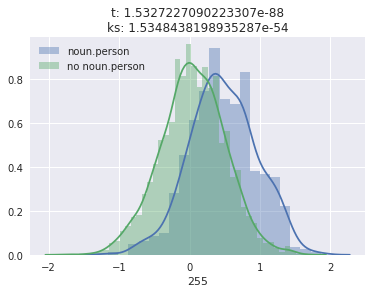

In [178]:
plot_by_presence(255, 'noun.person')

This dimension-feature pair is weakly negatively correlated using the original method ($r=-0.06$). Consistent with that, the distributions overlap a lot. However, a t test gives a small p value, suggesting the population means are different. 

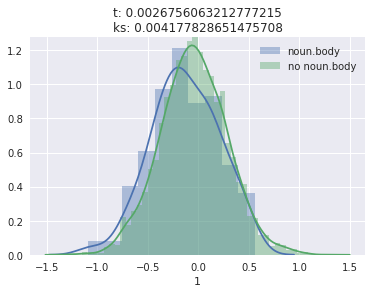

In [179]:
plot_by_presence(1, 'noun.body')

This is the distribution of p values from a t test for all dimension-feature pairs. I think it shows the inappropriateness of a t test more than anything else.

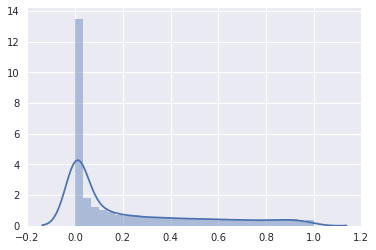

In [174]:
tmp = [do_ttest(i, f) for (i, f) in product(X.index, S.index)]
sns.distplot(tmp);

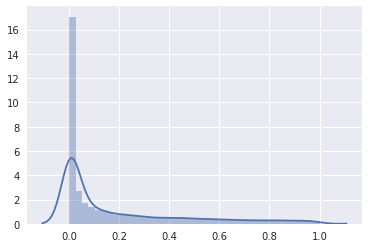

In [180]:
tmp = [do_2kstest(i, f) for (i, f) in product(X.index, S.index)]
sns.distplot(tmp);

## Old stuff that should be revisited

#### How sparse is the feature matrix?

93% of the entries in the feature matrix are zero.

In [ ]:
(subset.size - np.count_nonzero(subset.values)) / subset.size

#### On average, how correlated are the dimensions with the linguistic features?

This plot suggests "not really". In fact it looks very normal. That is, on average there is **no** correlation between the dimensions of a word embedding and linguistic features.

This plot isn't that interesting. It's telling me the average of 40 numbers is normally distributed, which comes from CLT.

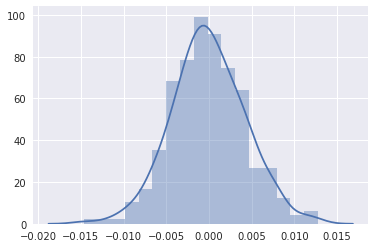

In [7]:
sns.distplot(correlations.mean(axis=1));

#### How correlated are the features and learnt dimensions?

This is a more meaningful plot. It says that the correlations are normally distributed around 0.

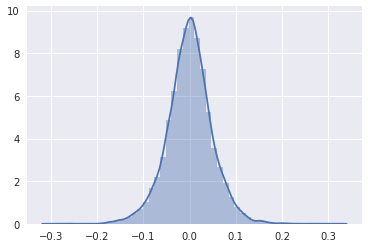

In [8]:
sns.distplot(correlations.values.flatten());

The following summary shows that the $(41*300)$ correlations are centered at 0 with std 0.05. The largest is 0.32, and the smallest is 0.30. These don't seem like very high numbers. The 75% percentile is 0.03. By looking back at the histogram above, it's obviously these dimensions are not highly correlated with these linguistic features.

Another important point from this is that the distribution of correlations is symmetric. So using the the max, rather than the max absolute, seems arbitrary. It doesn't allow for reversed dimensions.

In [9]:
pd.Series(correlations.values.flatten()).describe()

count    12300.000000
mean        -0.000063
std          0.048710
min         -0.298277
25%         -0.028078
50%          0.000444
75%          0.028427
max          0.318956
dtype: float64

#### What do the maximum correlations look like?

These are all positive. But are they different enough from 0? What test can I use here?

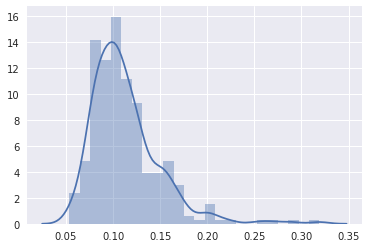

In [10]:
sns.distplot(correlations.max(axis=1));

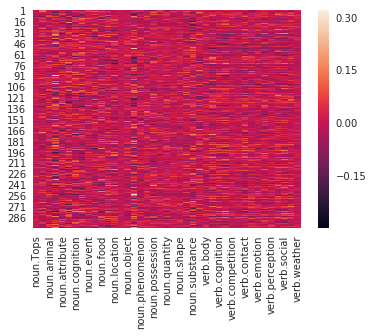

In [14]:
sns.heatmap(correlations);

## Todo
- Use different linguistic features (semantic, syntactic, etc.)
- Use different correlation metric
- Explore the correlations, alignments and top k words more
- Levin's verb classification

## Explore correlations, alignments and top k words

#### Top K words
In the paper they give the top K words for a dimension. The code prints, for each dimension, the dimension number, the aligned linguistic feature, the correlation between the two previous things, and the top k words associated with the dimension. I understand the last bit to mean "the k words with the highest value in the dimension".

In [ ]:
k = 50
top_k = pd.DataFrame(alignments, columns=['feature'])
top_k['correlation'] = correlations.max(axis=1)
tmp = pd.DataFrame([embeddings.loc[i].nlargest(n=k).index for i in top_k.index])
top_k = pd.merge(top_k, tmp, left_index=True, right_index=True)

top_k.head()

Most of these top words seem like junk. However, it'd be good to tease this apart a bit more. Here are some questions I'd like to ask:
- Are the top k words even of the right POS?
- Which features are missing (i.e. not the most correlated with any dimension)?
- How can I objectively measure whether the top k words are "correct"?

In [ ]:
def get_dims(feature, df=top_k):
    """Return the dimensions aligned with `feature` in `df`."""
    return df[df['feature']==feature]

get_dims('noun.animal')

#### Which features are not the most correlated with any dimension?

In [ ]:
subset.index.difference(top_k['feature'])

#### FrameNet

- What is the appropriate way to use FrameNet resources as features?

In [ ]:
from nltk.corpus import framenet as fn

fn.lus('happen.v')[1]

tagged_chunks[:20]